In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%run ClassSpecificMNIST.py

NUM_EPOCHS = 15
BATCH_SIZE = 100
LEARNING_RATE = 0.001
HIDDEN_NODE_LAYER_SIZE = 100

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
"""
Load the MNIST data. Split into train and test sets.
"""

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Train and test on all classes in MNIST
trainset = ClassSpecificMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = ClassSpecificMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Labeled as: 6


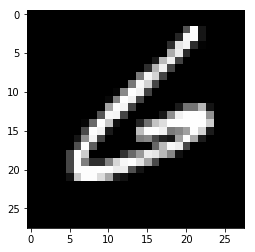

In [3]:
"""
Helper functions to view images.
"""

def imshow(img):
    img = img / 2 + 0.5     # unnormalize - corresponds to transformation above.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def heatshow(data):
    fig, axis = plt.subplots()
    heatmap = axis.pcolor(data, cmap=plt.cm.Blues)

    axis.set_yticks(np.arange(data.shape[0])+0.5, minor=False)
    axis.set_xticks(np.arange(data.shape[1])+0.5, minor=False)

    axis.invert_yaxis()
    fig.set_size_inches(50, 50)
    plt.colorbar(heatmap)

def view_recordings(recordings):
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 1
    for i in range(1, columns*rows+1):
        img = recordings[i-1][0]
        heatshow(img)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# View a random image
imshow(torchvision.utils.make_grid(images[0]))
print('Labeled as:', labels[0].item())

In [4]:
"""
Define Model
"""

class MNISTModel(nn.Module):
    
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.l1= nn.Linear(28*28, HIDDEN_NODE_LAYER_SIZE)
        self.l2 = nn.Linear(HIDDEN_NODE_LAYER_SIZE, HIDDEN_NODE_LAYER_SIZE)
        self.l3 = nn.Linear(HIDDEN_NODE_LAYER_SIZE, HIDDEN_NODE_LAYER_SIZE)
        self.l4 = nn.Linear(HIDDEN_NODE_LAYER_SIZE, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.sigmoid(self.l1(x))
        r1 = torchvision.utils.make_grid(x.to("cpu"))
        
        x = F.sigmoid(self.l2(x))
        r2 = torchvision.utils.make_grid(x.to("cpu"))
        
        x = F.sigmoid(self.l3(x))
        r3 = torchvision.utils.make_grid(x.to("cpu"))
        
        x = self.l4(x)
        x = F.log_softmax(x, dim=1)
        recordings = [r1, r2, r3]
        
        return x, recordings

In [5]:
"""
Instantiate a MNISTModel to be trained
"""

model = MNISTModel().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [6]:
"""
Train model
"""

for epoch in range(0, NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()

        preds, recordings = model(inputs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('Epoch: %d | loss: %.3f' % (epoch + 1, running_loss / 5000))

Epoch: 1 | loss: 0.108
Epoch: 2 | loss: 0.033
Epoch: 3 | loss: 0.023
Epoch: 4 | loss: 0.017
Epoch: 5 | loss: 0.014
Epoch: 6 | loss: 0.012
Epoch: 7 | loss: 0.011
Epoch: 8 | loss: 0.010
Epoch: 9 | loss: 0.009
Epoch: 10 | loss: 0.008
Epoch: 11 | loss: 0.007
Epoch: 12 | loss: 0.007
Epoch: 13 | loss: 0.006
Epoch: 14 | loss: 0.006
Epoch: 15 | loss: 0.005


In [7]:
"""
Test model
"""

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, targets = data
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        preds, recordings = model(inputs)
        _, predicted = torch.max(preds.data, 1) # max of logits
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 97 %


In [24]:
# Create a single class dataloader
fourset = ClassSpecificMNIST(root='./data', data_classes=[1], train=False, download=True, transform=transform)
fourloader = torch.utils.data.DataLoader(fourset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

zeroset = ClassSpecificMNIST(root='./data', data_classes=[7], train=False, download=True, transform=transform)
zeroloader = torch.utils.data.DataLoader(zeroset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

def get_recordings(model, dataloader, i=0):
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, targets = data
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            preds, recordings = model(inputs)
            if i == i:
                return recordings

In [27]:
"""
Record activations of single class
"""
fours_recordings = get_recordings(model, fourloader)
zeros_recordings = get_recordings(model, zeroloader)
        
# View a 200 batch sample
#view_recordings(recordings)

print('Fives:')
for rec in fours_recordings:
    print(torch.sum(rec - rec))
    
print('\nZeros:')
for rec in zeros_recordings:
    print(torch.sum(rec - rec))
    
print('\nSeven - Ones:')
for zero_rec, fours_rec in zip(zeros_recordings, fours_recordings):
    print(torch.sum(zero_rec - fours_rec))

Fives:
tensor(0.)
tensor(0.)
tensor(0.)

Zeros:
tensor(0.)
tensor(0.)
tensor(0.)

Seven - Ones:
tensor(-268.2905)
tensor(-352.8438)
tensor(-1125.4110)
